### Plan 
write code first drafts in jupyter notebook so I can better see output. Numbered files - 001, 002, 003, etc. Once code is finished, add script at end of code to convert it to a .py file. Import those functions into this outline. 


Once full pipeline is up and running, clean up this file and those function files and chat with Yoni. 

### Outline 

** for now: save and reload inputs and outputs at each step -> in addition try to run as if in full pipeline, don't need to save in between steps 
** each bullet = function

- 000 - process folders and file name (tbd)
    - need to be able to load all mp, mp_world, and yolo for one video for next steps
    - look at visibility score codein plot_vis_scores folder
- 001 ~~merge mediapipes and save world object~~
    - ~~negative Y~~
    - ~~add task info to df (horizontal or vertical, turn direction)~~
    - make inf values in mp 0? show where missing data -> interpolate. Right now, those rows don't load into df
        - check if similar issue for yolo
    - add section with template excel to manually exclude certain frames - ie, where Alexis said cutoff, visual review of videos
        - enter as time, convert to seconds 
- 002 ~~convert frames to time and add time column~~
- 003 save visbility plots: which landmarks visible, where do they drop off?
    - ~~save on per person, make all video together separate function~~
    - plot yolo visibility
    - make sure "inf" shown as zero
    - update plot code to see if I can make prettier + move label - https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html#a-figure-with-just-one-subplot 
- 004 - ID turns, walking toward away from camera
    - ~~move filter code to own function and .py file~~
    - make inputs for peaks and filters and input to function so I can test differences easily
        - make distance for find_peaks relative to fps?
        - after_peak_flattening_all = cutoff for distance from midpoint to consider, make relative to fps
    -  --------------------------------------------------
    - filter max hip z distance (turn midpoint) - need to be above a cutoff threshold to be considered a turn
        - see NW videos for examples
    - adjust gradient: difference over 5 frames rather than each frame?
    - adjust atol (atol bigger I think) - make turn time shorter (goal, inside my turn time markers)
    - INTERPOLATE: look at NW HC gait vertical right shoulders 
    - reminder: make cutoff - hip visibility has to be greater than X to track turns, shoulder greater than Y to track away vs towards
    - remove turns that are too short to actually be a turn
        - ie: less than half a second or something  
- 005 calculate gait metrics
    - double support
        - try ipsilateral hip vs heel y distance rather than heel y distance 
        - one single stride - cutoff for "good" stride
        - gradient: difference over 5 frames
    - reminder: check for when participants are moving away from camera (from double support plots, heel seems funky when moving away from camera, but ok when moving toward camera )
        - especially for stride time 
    - reminder: check if R and L is correctly labelled if R vs L matters for output
        - may be mixing up right and left as person walks toward and away from camera 
    - reminder: use filtering code in sandbox
    - reminder: for peaks, use distance and prominience features to select peaks
    - reminder: should I try heel strike + toe off method from double stance code? or use already validated peaks and mins
    - reminder: check inputs - only filepath should be vid_in_path, not mp or yolo
    - update code: check if Y needs to be negative now? added neg column at merge step 
    - one function per metrics
    - calculate metrics over
        - whole walk
        - each sub-section of walk: walk away, walk toward, etc
        - stats: save mean, median, std, %CV, etc for whole walk and sub-section of walk
        - maybe for loop in main script?? rather than within function
    - some kind of cutoff specific to each metric (marker present and visible above certain score)
        - calculate over all frames where it is present
        - doesn't have to be all strides! only count "good strides" Rich 
    - use gait metrics excel and gait ID vertical as outline 
- video quality metrics: video length, Hz, etc
    - reminder: check inputs - only filepath should be vid_in_path, not mp or yolo

- potential functions to add
    - check for missing data (mp_all_df.isnull().sum(), mp_all_df.isna().sum(), etc) 
    - interpolation from Stenum paper? see how many are missing
        - DS_HC vertical right - has missing values 
    - Filter
    - plots to compare accuracy when moving mean, interpolation, or filtering facotrs are changed

- reminder: check inputs - only filepath should be vid_in_path, not mp or yolo

- for two BW participants: run on home video, run on mojito in-clinic video and write script to compare:
  - per participants and for both participants
    1) home video vs in person BW video
    2) home video vs zeno mat
    3) in person BW video vs zeno mat
 
- reminder: clean up jupyter notebook and .py files once full script works
    - remove original input file paths, etc

       

In [1]:
# import libraries 
import pandas as pd 
import numpy as np 
import os 

In [2]:
# import functions from sandbox src code files 
from sandbox_main_src_funs.merge_mp_yolo_dfs import (merge_mp_pose_world, add_orientation_and_turn_direction, save_merge_mp_yolo_df)

from sandbox_main_src_funs.frames_to_time import (get_frames_per_second, add_time_column, save_df_w_time)

from sandbox_main_src_funs.landmark_visibility import (vis_all_labels_boxplot, 
save_visibility_boxplot, vis_lineplot, save_visibility_lineplot,
save_vis_stats_by_label, save_vis_scores_csv)

from sandbox_main_src_funs.segment_video_walk_turn import filter_landmark_single_axis, segment_video_walks_turn

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'merge_mp_yolo_dfs.ipynb' matched no files


This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'frames_to_time.ipynb' matched no files
[NbConvertApp] WARNING | pattern 'landmark_visibility.ipynb' matched no files


This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'segment_video_walk_turn.ipynb' matched no files


In [3]:
# input - eventually will need to edit this to incorporate into main hva pipeline 

# path to video 
vid_in_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\hva_code\HomeVideoAnalysis\tests\fixtures\all_videos\RB_HC_practice videos\RB_HC_gait_vertical_right.MOV' # vid_in_path set during process_dir() of run.py

# load mp, mp_world, and yolo .csv files for one video (from main branch, output of home video analysis run.py 8/29/2024)
mp_pose_filepath = r'..\temp\main_branch_outputs\000_run\RB_HC_gait_vertical_right_mediapipe.csv'
mp_world_filepath = r'..\temp\main_branch_outputs\000_run\RB_HC_gait_vertical_right_mediapipe_world.csv'
yolo_filepath = r'..\temp\main_branch_outputs\000_run\RB_HC_gait_vertical_right_yolo.csv'

mp_pose_basename = os.path.splitext(os.path.basename(mp_pose_filepath))[0]
mp_all_filepath = mp_pose_basename + '_all.csv'

# output folder 
output_parent_folder = r'..\temp\test_sandbox_pipeline_outputs'

# read csv 
mp_pose_df = pd.read_csv(mp_pose_filepath)
mp_world_df = pd.read_csv(mp_world_filepath)
yolo_df = pd.read_csv(yolo_filepath)

In [4]:
# step 001 - merge mp df, add tasks info and negative Y
[mp_all_df, yolo_df] = merge_mp_pose_world(mp_pose_df, mp_world_df, yolo_df)
[mp_all_df, yolo_df] = add_orientation_and_turn_direction(vid_in_path, mp_all_df, yolo_df)
save_merge_mp_yolo_df(mp_all_df, yolo_df, vid_in_path, output_parent_folder)

# outputs 
# mp_all_df and yolo_df pandas data frames updated and .csv file saved                    

In [5]:
# step 002 - get frames per second and add time column 
fps = get_frames_per_second(vid_in_path)
[mp_all_df, yolo_df] = add_time_column(mp_all_df, yolo_df, fps)
save_df_w_time(mp_all_df, yolo_df, vid_in_path, output_parent_folder)
# outputs 
# fps = video frames per second 
# [mp_all_df, yolo_df]: panda data frames added seconds and .csv file saved 

In [6]:
# step 003 - plot and save landmark visibility scores 

# boxplot 
boxplot = vis_all_labels_boxplot(mp_all_df, vid_in_path)
save_visibility_boxplot(boxplot, vid_in_path, output_parent_folder)

# lineplot 
lineplot = vis_lineplot(mp_all_df, vid_in_path)
save_visibility_lineplot(lineplot, vid_in_path, output_parent_folder)

# calculate and save vis score per label 
vis_stats_df = save_vis_stats_by_label(mp_all_df)
save_vis_scores_csv(vis_stats_df, vid_in_path, output_parent_folder)

# outputs: save boxplot and lineplot .png and vis_stats_df with mean, standard deviation, and median visibility for each marker

label is na: skipped


C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\hva_code\HomeVideoAnalysis\megan_sandbox\sandbox_main_src_funs\landmark_visibility.py:140: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  vis_stats_df = pd.concat([vis_stats_df, current_vis_stats_row])


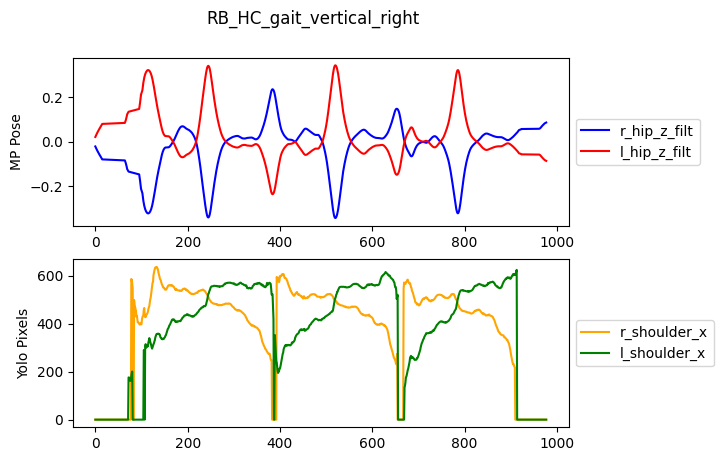

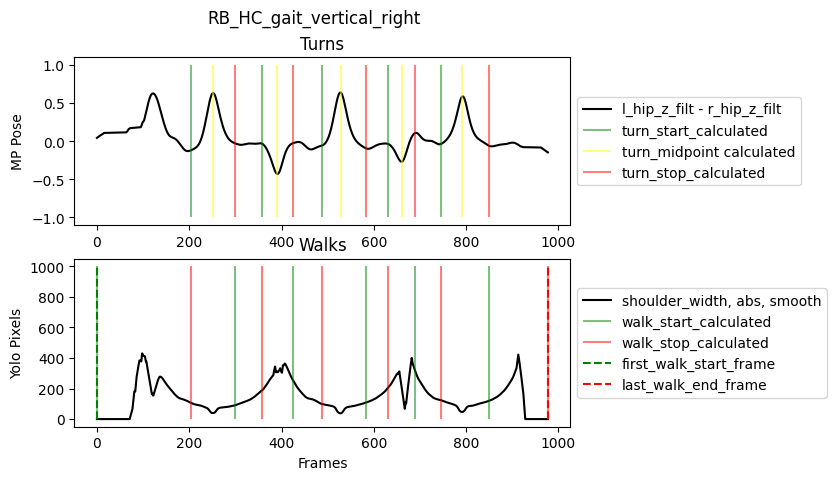

In [7]:
# step 004 - segment when person is walking toward or away from camera or turning 
[turn_df, walks_df] = segment_video_walks_turn(mp_all_df, yolo_df, fps, vid_in_path, output_parent_folder,
                                               cutoff = 0.4, order = 1,
                                               find_peaks_distance = 200, # min distance between hip z distance peaks  
                                               find_peaks_prominence = 0.2, # hip Z peaks need to be greater than this value 
                                               flattening_point_atol = 0.0025, # Distance of hip z diff away from zero to be identified as "flattening point"
                                               dist_turn_mid_to_flattening = 20) # flattening point has to be at least this many frames from turn midpoint

# outputs 
# turn_df: pandas data frame with frames for each turn start, stop, and midpoint; also saved as .csv 
# walks_df: pandas data frame with frames for each walk start, stop, and midpoint and if walk was toward or away from camera; also saved as .csv 
# 2 plots saved as .png with turn/walk start stop and hip and shoulder distances 
